In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import copy
from astropy.visualization import quantity_support
from astropy.table import Table, QTable
import matplotlib
import astropy.units as u
from astroduet.config import Telescope
from astroduet.background import background_pixel_rate
font = {'size'   : 22}
from astroduet.models import Simulations, fits_file, load_model_ABmag, load_model_fluence
matplotlib.rc('font', **font)
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
import astroduet.image_utils

In [2]:
## Do it only once
# sims = Simulations()
# sims.parse_emgw()

In [3]:
def create_and_plot_lc(*args, **kwargs):
    lightcurve = get_lightcurve(*args, **kwargs)
    plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 1, hspace=0)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)
    good = (lightcurve['snr_D1'].value > 1) | (lightcurve['snr_D2'].value > 1)
    lightcurve = lightcurve[good]
#     ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['ABmag_D1'].value, 
#                  fmt='o', markersize=2, yerr=lightcurve['ABmag_D1_err'].value)
#     ax0.errorbar(lightcurve['time'].value / 86400, lightcurve['ABmag_D2'].value, 
#                  fmt='o', markersize=2, yerr=lightcurve['ABmag_D2_err'].value)
    ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D1'].value, s=2)
    ax1.scatter(lightcurve['time'].value / 86400, lightcurve['snr_D2'].value, s=2)
    print(lightcurve['snr_D2'])

    ax0.set_ylabel("AB mag")
    ax1.set_ylabel("S/R")
    ax1.set_xlabel("Time (d)")
#     ymin = min(lightcurve['ABmag_D1'].value.min(), lightcurve['ABmag_D2'].value.min()) - 1
#     ymax = max(lightcurve['ABmag_D1'].value.max(), lightcurve['ABmag_D2'].value.max()) + 1
    # Inverted ax for magnitude
#     ax0.set_ylim([ymax, ymin])
#    ax1.semilogx();
    

[12.05996585 17.86087799 21.27074962 23.64339092 25.41486014 26.7921494
 27.88639968 32.26129203 32.26421165 32.24484327 32.20688498 32.15256633
 32.08163915 31.99740115 30.0643543  29.88188045 29.69390148 29.50325712
 29.31151585 29.11769646 28.92076445 26.2378644  26.03168639 25.82410922
 25.61652483 25.41461819 25.2126644  25.00934023 22.38838297 22.19100353
 22.00197477 21.81711854 21.63101019 21.4436265  21.25494357 18.89915285
 18.72877377 18.55724265 18.38453857 18.21064001 18.04233147 17.88515874
 15.83449667 15.68372014 15.53196807 15.3792239  15.22849806 15.09165481
 14.95668379 13.19520803 13.06948636 12.94304065 12.81586019 12.68793402
 12.55925093 12.42979946 10.91941202 10.81933968 10.72032699 10.62083914
 10.52087041 10.42041496 10.31946684  9.04931357  8.9603556   8.87099805
  8.78123648  8.69106638  8.60048316  8.50948215  7.45773707  7.37957454
  7.30109253  7.22228786  7.14315729  7.06369756  6.99136878  6.12821387
  6.06118427  5.99391312  5.92639832  5.86372948  5.

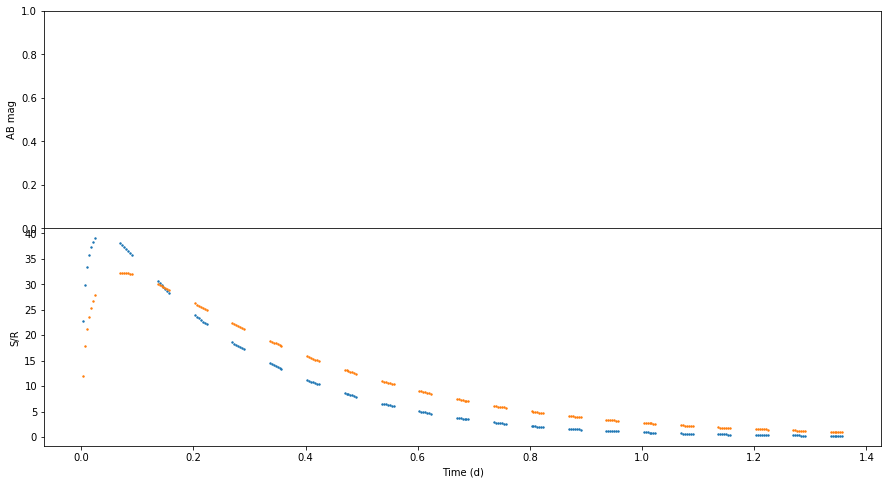

In [4]:
create_and_plot_lc('shock_2.5e10.dat', distance=100e6*u.pc)

Now specifying the observing window...

In [5]:
def plot_realistic_lightcurve(lightcurve, exposure, label=None, debug=False):
    # Set debug to True to dump all intermediate images.
    lightcurve = lightcurve_through_image(lightcurve, exposure=exposure, debug=debug)
    lightcurve_rebin = lightcurve_through_image(lightcurve, exposure=exposure, 
                                                final_resolution=1200*u.s, debug=debug)
    plt.figure(figsize=(15, 10))
    for lc in lightcurve, lightcurve_rebin:
        good1 = (lc['fluence_D1_fit'] > 0)&(lc['fluence_D1_fiterr'] < lc['fluence_D1_fit'])
        good2 = (lc['fluence_D2_fit'] > 0)&(lc['fluence_D2_fiterr'] < lc['fluence_D2_fit'])
        good = good1&good2
        plt.errorbar(lc['time'].value[good] / 86400, 
                     lc['fluence_D1_fit'][good], 
                     yerr=lc['fluence_D1_fiterr'][good], fmt='o')
        plt.errorbar(lc['time'].value[good] / 86400, 
                     lc['fluence_D2_fit'][good], 
                     yerr=lc['fluence_D2_fiterr'][good], fmt='s')
    plt.xlabel("Time (d)")
    plt.ylabel("Flux")
    plt.title(label)


100%|██████████| 35/35 [00:14<00:00,  2.34it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


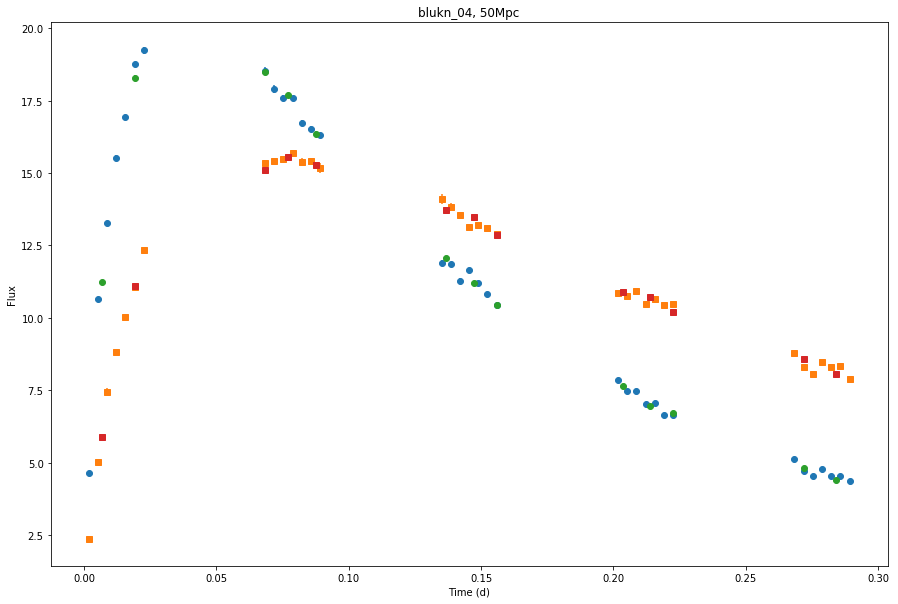

In [6]:
plot_realistic_lightcurve(
    get_lightcurve("shock_2.5e10.dat", 
                   observing_windows=np.array([[0, 30000]]) * u.s, 
                   distance=50e6*u.pc), 
                   300 * u.s, label="blukn_04, 50Mpc", debug=False)

In [7]:
## In case someone wants to take a look at the debug images...
## set debug=False in plot_realistic_lightcurves and look at them

def plot_debug_images(directory):
    from astroduet.image_utils import find, run_daophot
    img_pickles = glob.glob(os.path.join(directory, '*.p'))
    for img_pickle in img_pickles:
        with open(img_pickle, 'rb') as fobj:
            img = pickle.load(fobj)
        image1 = img['imgD1']
 
        plt.figure(figsize=(10, 10))
        plt.title(img_pickle)
        plt.imshow(image1)
    
# plot_debug_images('debug_imgs_1200.0s_96486629')

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
100%|██████████| 41/41 [00:25<00:00,  1.64it/s]


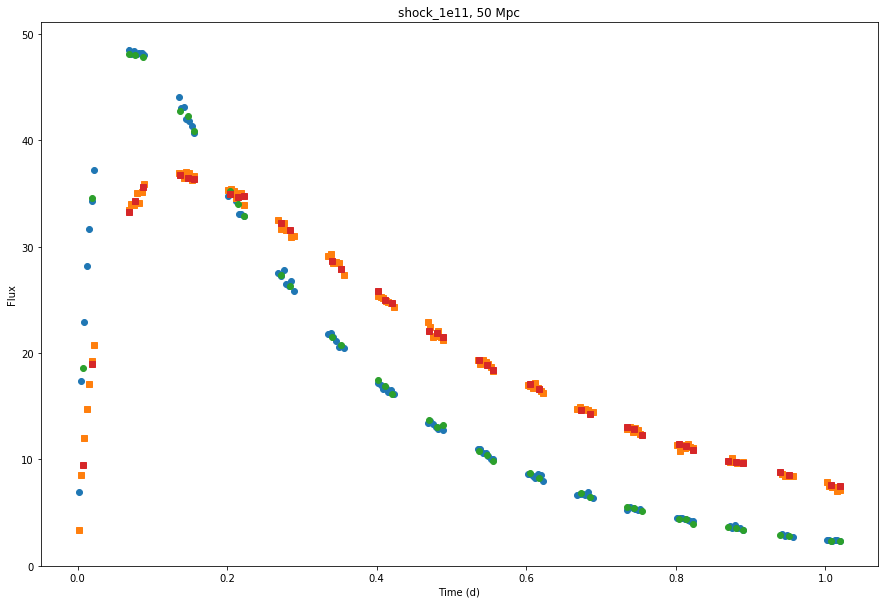

In [8]:
plot_realistic_lightcurve(
    get_lightcurve("../astroduet/data/shock_1e11_lightcurve_DUET.fits",
                   observing_windows=np.array([[0, 90000]]) * u.s, 
                   distance=50e6*u.pc),  
                   300 * u.s, 
                   label='shock_1e11, 50 Mpc', debug=False)
